In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
# Download required NLTK data
nltk.download("stopwords")
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yazeed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yazeed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Read datasets
#df_train = pd.read_csv(r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/train.txt', names=['Text', 'Emotion'], sep=';')
#df_val = pd.read_csv(r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/val.txt', names=['Text', 'Emotion'], sep=';')
#df_test = pd.read_csv(r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/test.txt', names=['Text', 'Emotion'], sep=';')

In [3]:
# Data Loading
def load_data(train_path, val_path, test_path):
    df_train = pd.read_csv(r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/train.txt', names=['Text', 'Emotion'], sep=';')
    df_val = pd.read_csv(r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/train.txt', names=['Text', 'Emotion'], sep=';')
    df_test = pd.read_csv(r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/train.txt', names=['Text', 'Emotion'], sep=';')
    return df_train, df_val, df_test


In [9]:
# File paths
train_path = r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/train.txt'
val_path = r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/val.txt'
test_path = r'E:\Data science 2022-Epsilon\Deeplearning Amit\Final project/test.txt'

# Load data
df_train, df_val, df_test = load_data(train_path, val_path, test_path)

In [11]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [18]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

In [19]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: Emotion, dtype: float64

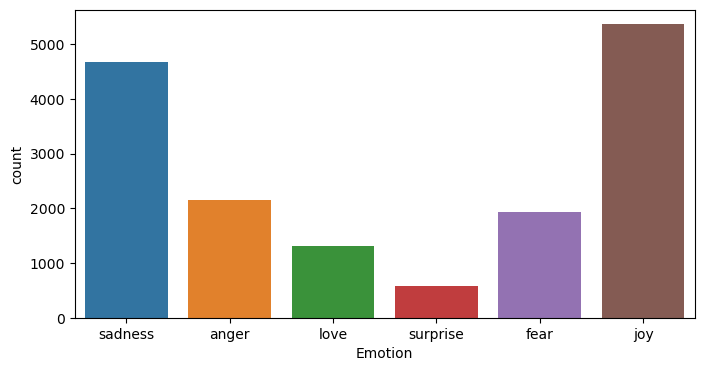

In [20]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

- The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [21]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [22]:
#print the number of duplicated values 
df_train.duplicated().sum()

1

In [23]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [24]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [25]:
# Text Preprocessing Functions
def lemmatization(text):
    text = text.split()
    text = [lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)


In [26]:
def remove_stop_words(text):
    text = [i for i in str(text).split() if i not in stop_words]
    return " ".join(text)

In [27]:
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [28]:
def lower_case(text):
    text = text.split()
    text = [y.lower() for y in text]
    return " ".join(text)

In [29]:
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', "")
    text = re.sub('\s+', ' ', text)
    return text.strip()

In [30]:

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [31]:
def normalize_text(df):
    df.Text = df.Text.apply(lambda text: lower_case(text))
    df.Text = df.Text.apply(lambda text: remove_stop_words(text))
    df.Text = df.Text.apply(lambda text: remove_numbers(text))
    df.Text = df.Text.apply(lambda text: remove_punctuations(text))
    df.Text = df.Text.apply(lambda text: remove_urls(text))
    df.Text = df.Text.apply(lambda text: lemmatization(text))
    return df

In [32]:
def normalized_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_punctuations(sentence)
    sentence = remove_urls(sentence)
    sentence = lemmatization(sentence)
    return sentence

In [33]:
# Model Building Functions
def prepare_data(df_train, df_val, df_test):
    # Prepare features and labels
    X_train = df_train['Text']
    y_train = df_train['Emotion']
    X_val = df_val['Text']
    y_val = df_val['Emotion']
    X_test = df_test['Text']
    y_test = df_test['Emotion']
    
    # Encode labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)
    
    # Convert to categorical
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), le


In [34]:
def create_sequences(X_train, X_val, X_test, max_words=10000, maxlen=100):
    # Tokenize texts
    tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
    tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))
    
    # Convert texts to sequences
    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_val = tokenizer.texts_to_sequences(X_val)
    sequences_test = tokenizer.texts_to_sequences(X_test)
    
    # Pad sequences
    X_train = pad_sequences(sequences_train, maxlen=maxlen)
    X_val = pad_sequences(sequences_val, maxlen=maxlen)
    X_test = pad_sequences(sequences_test, maxlen=maxlen)
    
    return X_train, X_val, X_test, tokenizer


In [35]:
def build_model(vocab_size, max_length):
    model = Sequential([
        Embedding(vocab_size, 100, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128):
    callback = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[callback]
    )
    
    return history

In [37]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training loss')
    ax2.plot(history.history['val_loss'], label='Validation loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


In [38]:
def predict_emotion(text, model, tokenizer, le, maxlen=100):
    # Preprocess the text
    text = normalized_sentence(text)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded = pad_sequences(sequence, maxlen=maxlen)
    
    # Predict
    prediction = model.predict(padded)
    
    # Get the predicted emotion and probability
    emotion = le.inverse_transform([prediction.argmax(axis=-1)[0]])[0]
    probability = np.max(prediction)
    
    return emotion, probability

Epoch 1/20
125/125 [==============================] - 314s 2s/step - loss: 1.4824 - accuracy: 0.3758 - val_loss: 0.8239 - val_accuracy: 0.7089
Epoch 2/20
125/125 [==============================] - 302s 2s/step - loss: 0.5739 - accuracy: 0.7974 - val_loss: 0.3059 - val_accuracy: 0.8979
Epoch 3/20
125/125 [==============================] - 304s 2s/step - loss: 0.3024 - accuracy: 0.8941 - val_loss: 0.1743 - val_accuracy: 0.9496
Epoch 4/20
125/125 [==============================] - 272s 2s/step - loss: 0.1922 - accuracy: 0.9374 - val_loss: 0.1143 - val_accuracy: 0.9670
Epoch 5/20
125/125 [==============================] - 271s 2s/step - loss: 0.1317 - accuracy: 0.9579 - val_loss: 0.0788 - val_accuracy: 0.9768
Epoch 6/20
125/125 [==============================] - 278s 2s/step - loss: 0.0943 - accuracy: 0.9694 - val_loss: 0.0602 - val_accuracy: 0.9806
Epoch 7/20
125/125 [==============================] - 283s 2s/step - loss: 0.0715 - accuracy: 0.9759 - val_loss: 0.0465 - val_accuracy: 0.9854

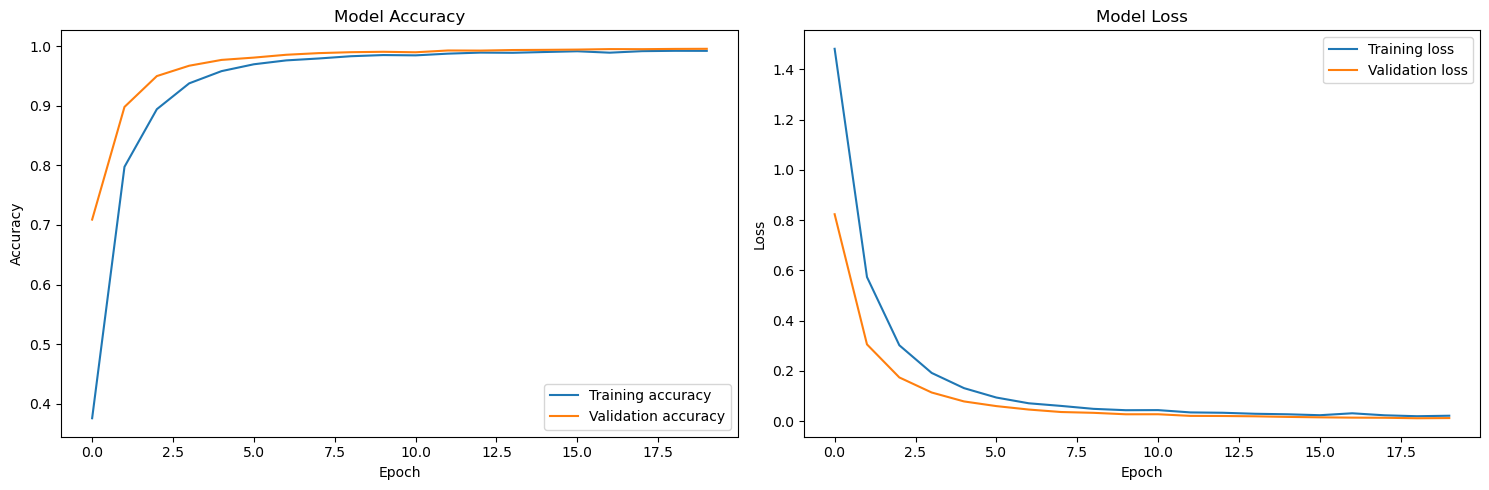


Example predictions:
1/1 [==============================] - 2s 2s/step

Text: I'm so happy about getting into university!
Predicted emotion: joy (confidence: 1.00)
1/1 [==============================] - 0s 71ms/step

Text: I'm really angry about what happened yesterday.
Predicted emotion: anger (confidence: 1.00)
1/1 [==============================] - 0s 61ms/step

Text: I feel so sad and lonely today.
Predicted emotion: sadness (confidence: 1.00)
1/1 [==============================] - 0s 67ms/step

Text: That's amazing! I can't believe it!
Predicted emotion: fear (confidence: 0.88)


In [39]:
# Main execution block
if __name__ == "__main__":
    try:
        # Load data
        df_train, df_val, df_test = load_data('train.txt', 'val.txt', 'test.txt')
        
        # Preprocess text
        df_train = normalize_text(df_train)
        df_val = normalize_text(df_val)
        df_test = normalize_text(df_test)
        
        # Prepare data
        (X_train, y_train), (X_val, y_val), (X_test, y_test), le = prepare_data(df_train, df_val, df_test)
        
        # Create sequences
        X_train, X_val, X_test, tokenizer = create_sequences(X_train, X_val, X_test)
        
        # Build and train model
        vocab_size = len(tokenizer.word_index) + 1
        model = build_model(vocab_size, X_train.shape[1])
        history = train_model(model, X_train, y_train, X_val, y_val)
        
        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"\nTest accuracy: {test_accuracy:.4f}")
        
        # Plot training history
        plot_training_history(history)
        
        # Example predictions
        test_sentences = [
            "I'm so happy about getting into university!",
            "I'm really angry about what happened yesterday.",
            "I feel so sad and lonely today.",
            "That's amazing! I can't believe it!"
        ]
        
        print("\nExample predictions:")
        for sentence in test_sentences:
            emotion, probability = predict_emotion(sentence, model, tokenizer, le)
            print(f"\nText: {sentence}")
            print(f"Predicted emotion: {emotion} (confidence: {probability:.2f})")
                
        # Save model
        model.save('emotion_recognition_model.keras')
        
    except FileNotFoundError:
        print("Error: One or more data files not found. Please ensure 'train.txt', 'val.txt', and 'test.txt' exist in the current directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Lime



In [41]:
from lime.lime_text import LimeTextExplainer


1/1 [==============================] - 0s 72ms/step


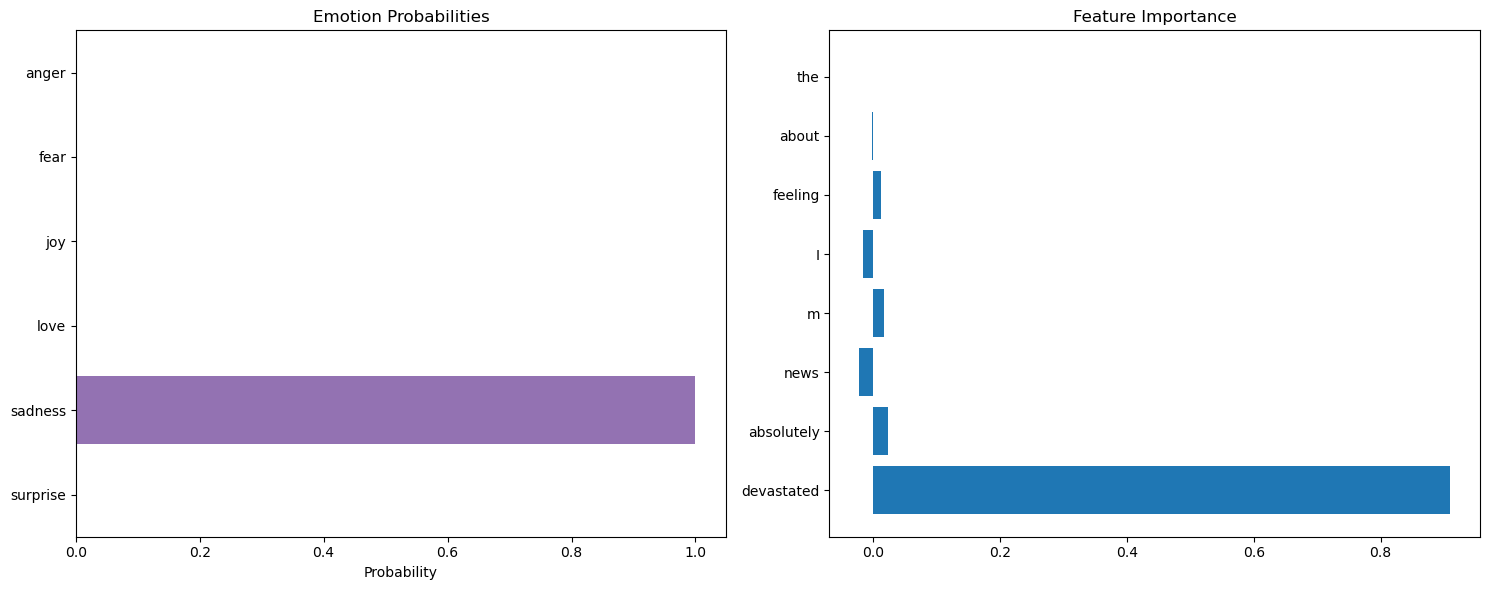

Single Text Analysis:
Text: I'm feeling absolutely devastated about the news
Predicted: sadness
Confidence: 1.00

1/1 [==============================] - 0s 76ms/step


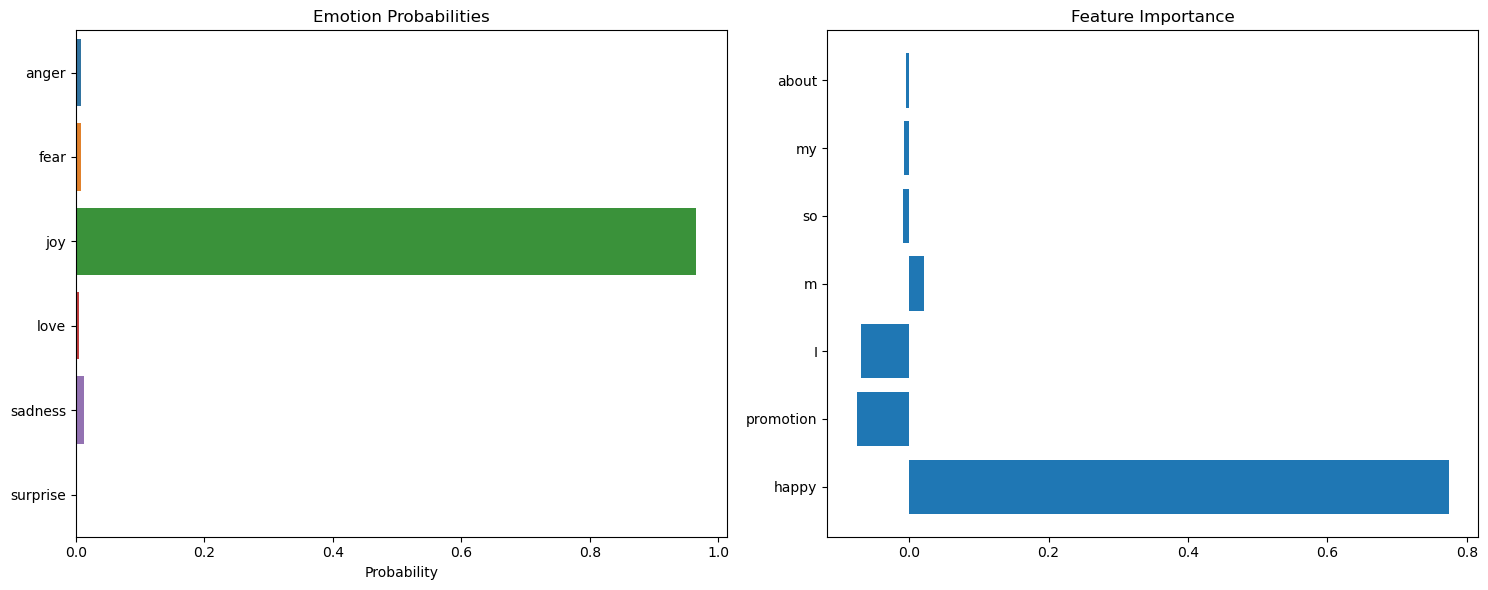

1/1 [==============================] - 0s 79ms/step


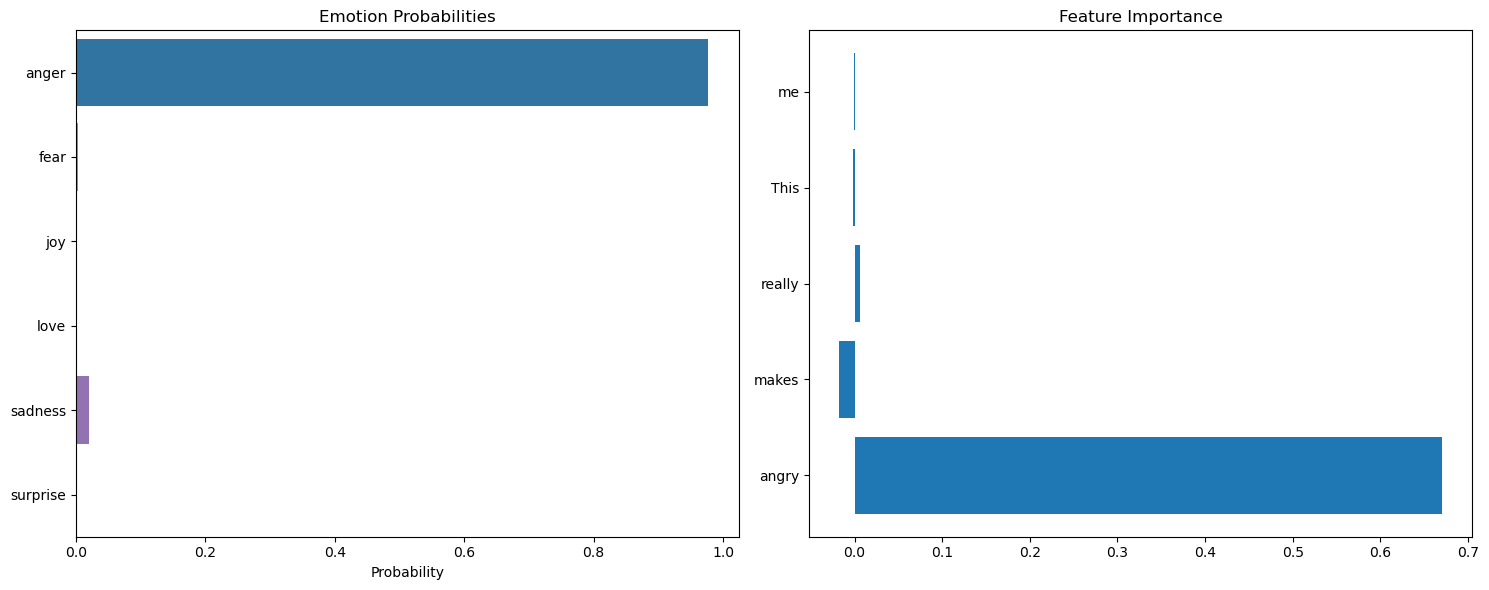

1/1 [==============================] - 0s 70ms/step


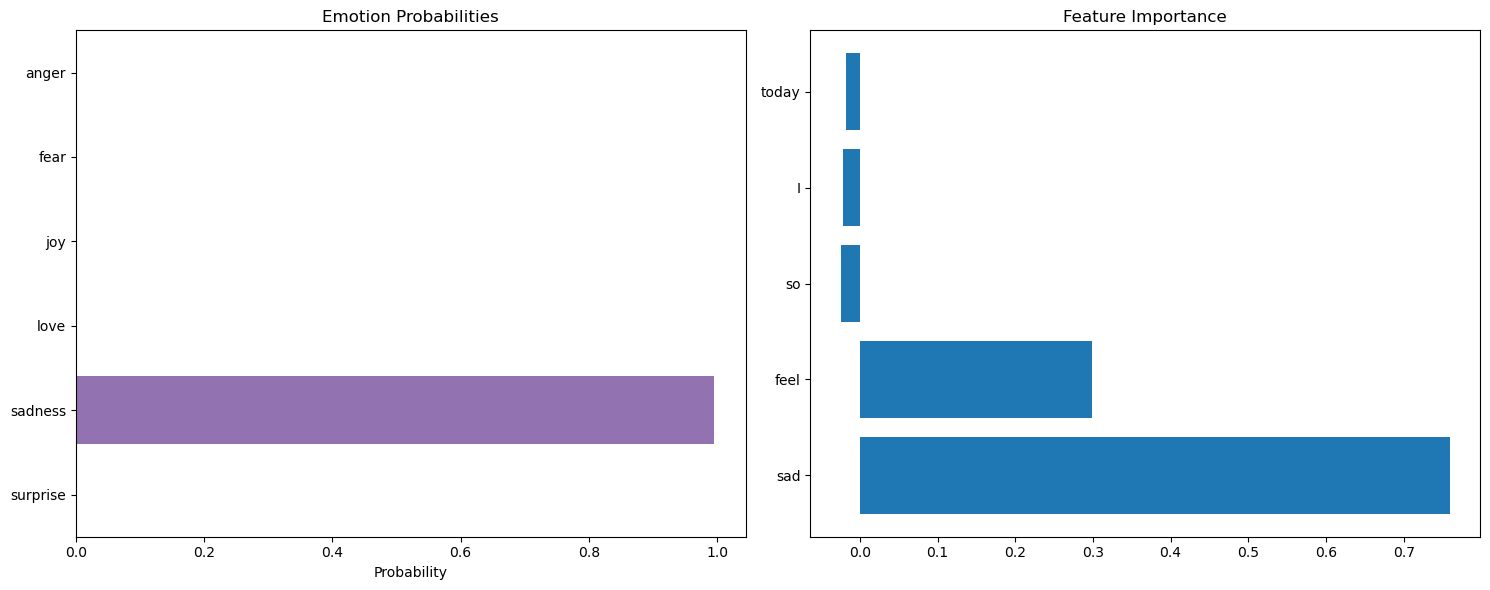

1/1 [==============================] - 0s 66ms/step


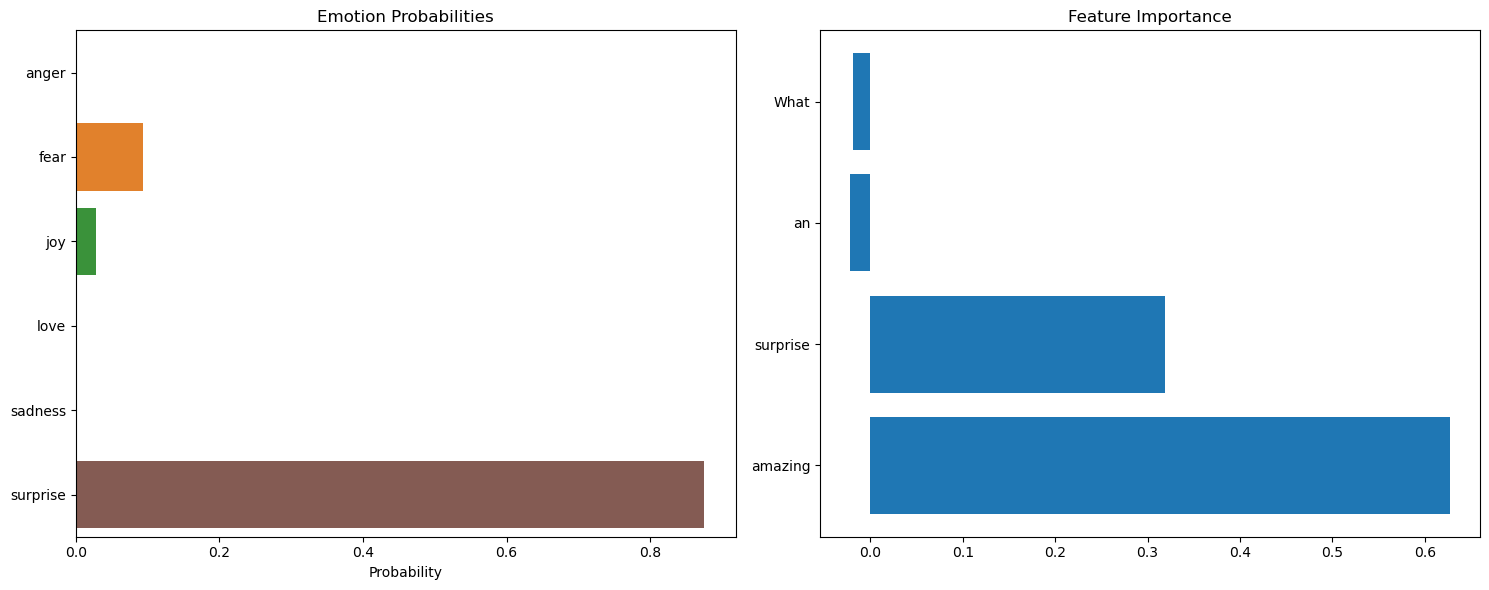

1/1 [==============================] - 0s 66ms/step


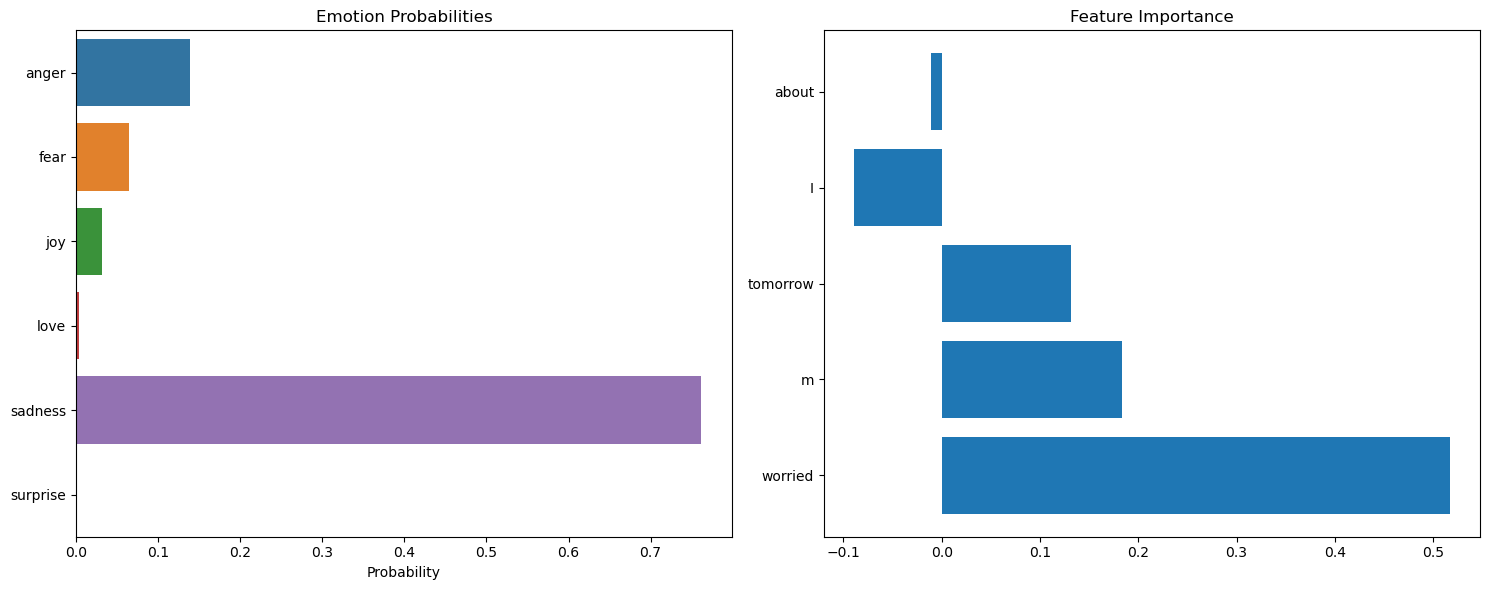

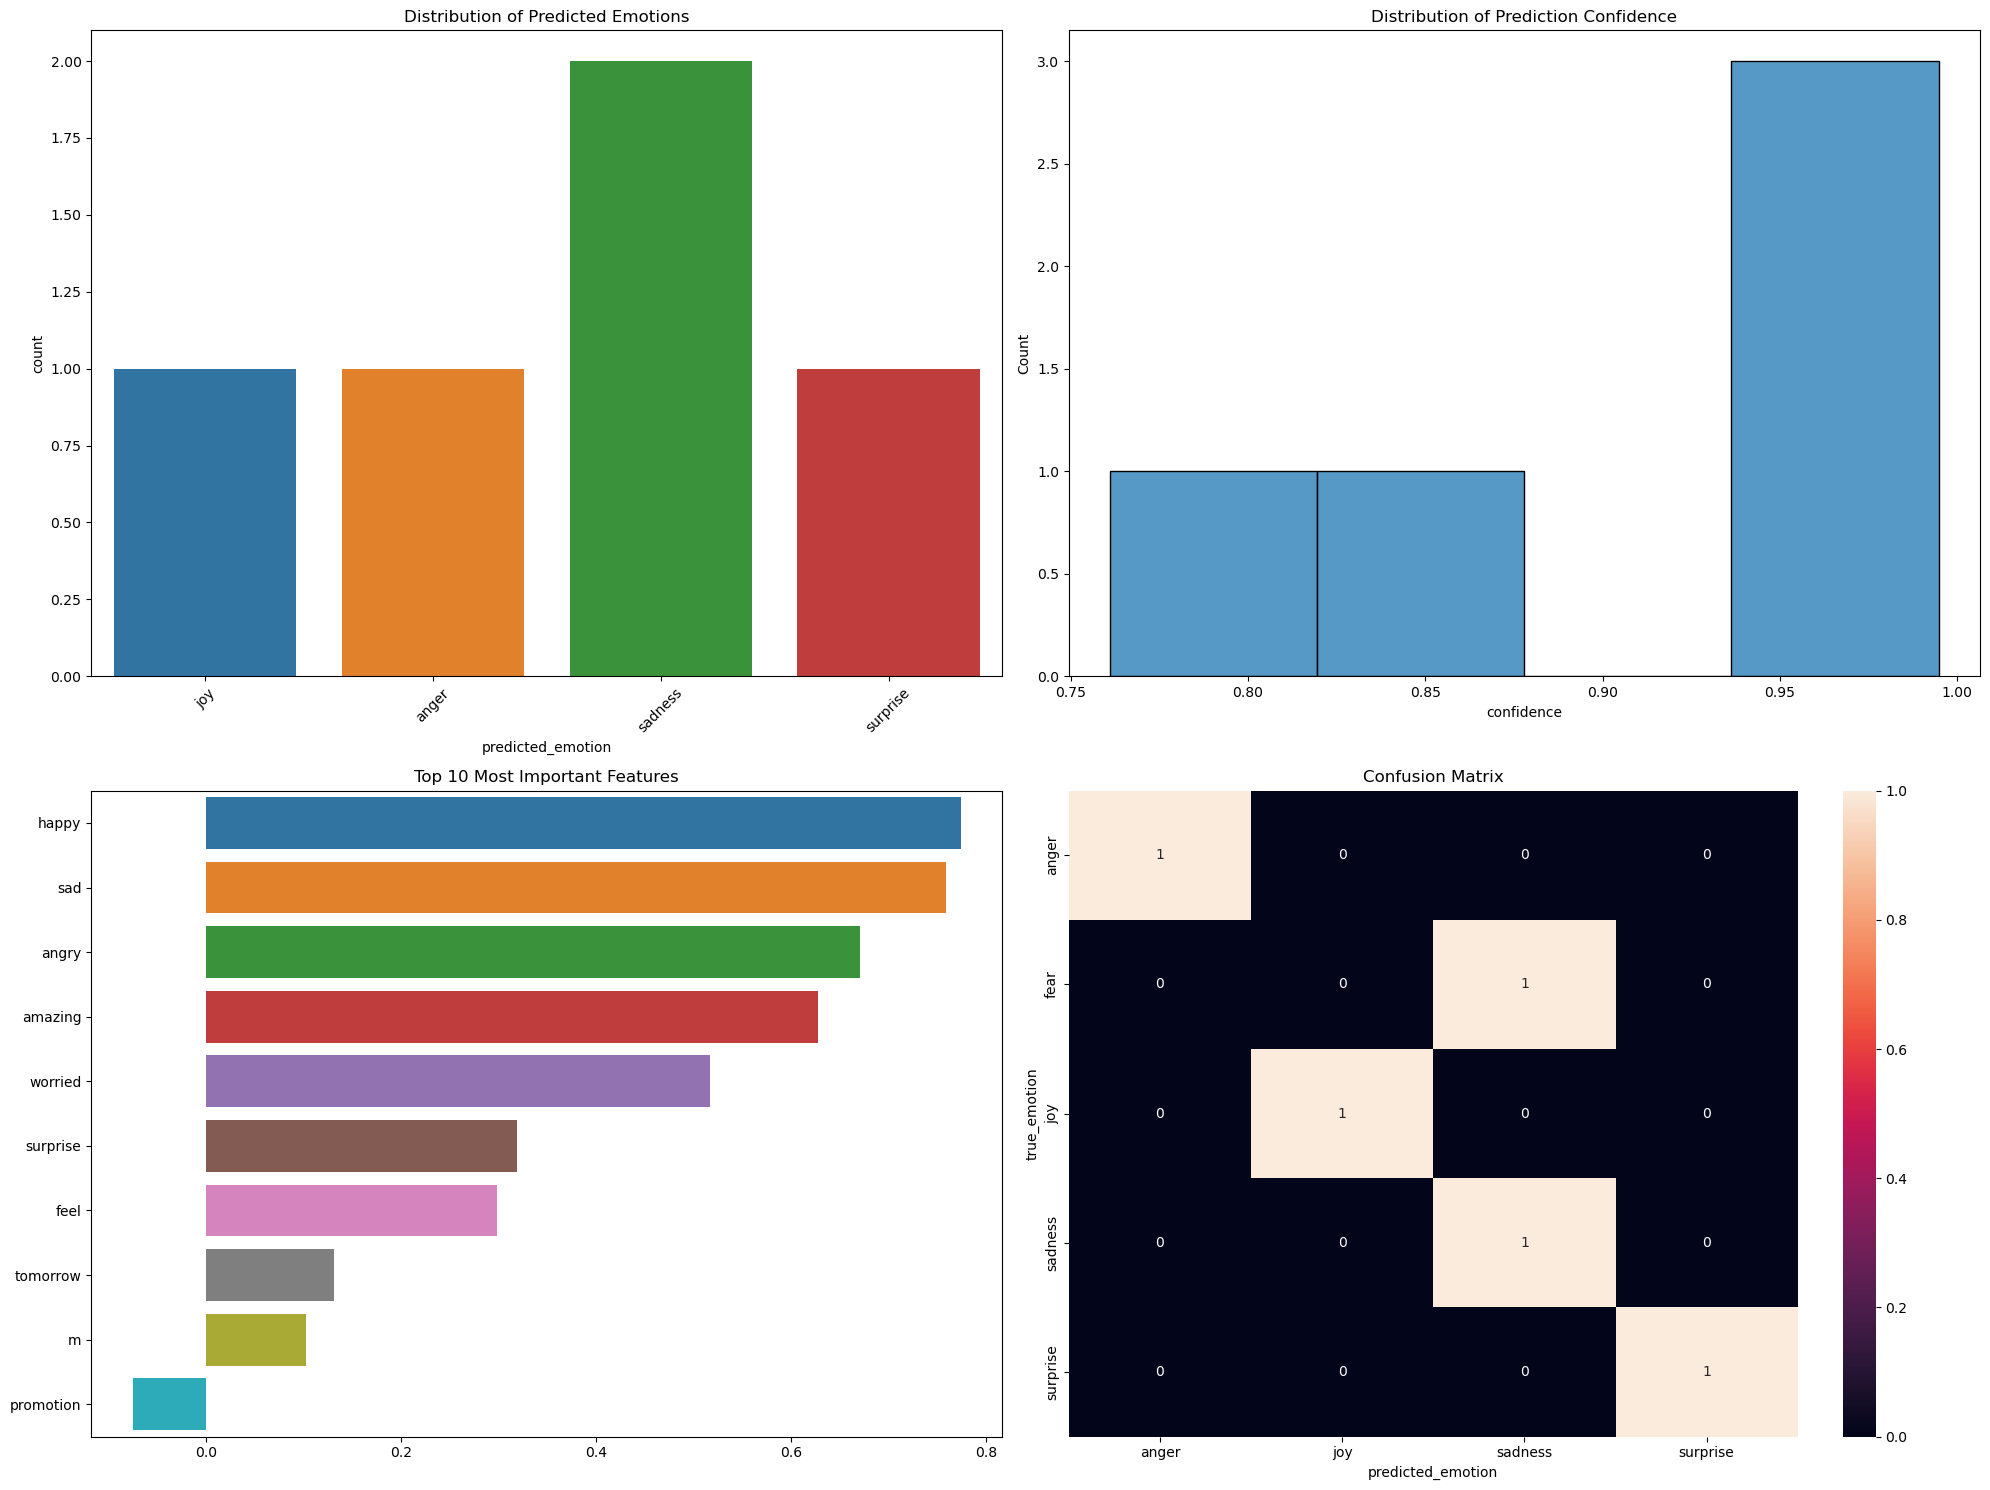

1/1 [==============================] - 0s 63ms/step

Misclassified Examples:
                         text true_emotion predicted_emotion  confidence  \
4  I'm worried about tomorrow         fear           sadness    0.761114   

   confidence_diff  
4         0.696933  


In [42]:
from collections import defaultdict

class EmotionLIMEAnalyzer:
    def __init__(self, model, tokenizer, label_encoder):
        self.model = model
        self.tokenizer = tokenizer
        self.le = label_encoder
        self.explainer = LimeTextExplainer(class_names=self.le.classes_)
        
    def predict_proba_wrapper(self, texts):
        processed_texts = [normalized_sentence(text) for text in texts]
        sequences = self.tokenizer.texts_to_sequences(processed_texts)
        padded_sequences = pad_sequences(sequences, maxlen=100)
        return self.model.predict(padded_sequences)
    
    def analyze_single_text(self, text, num_features=10):
        """Analyze a single text with detailed visualization."""
        # Get LIME explanation
        exp = self.explainer.explain_instance(
            text,
            self.predict_proba_wrapper,
            num_features=num_features,
            top_labels=len(self.le.classes_)
        )
        
        # Get predicted probabilities
        probs = self.predict_proba_wrapper([text])[0]
        predicted_class = self.le.classes_[probs.argmax()]
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot probability distribution
        emotions = self.le.classes_
        sns.barplot(x=probs, y=emotions, ax=ax1)
        ax1.set_title('Emotion Probabilities')
        ax1.set_xlabel('Probability')
        
        # Plot feature importance
        features, importances = zip(*exp.as_list(label=probs.argmax()))
        y_pos = range(len(features))
        ax2.barh(y_pos, importances)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(features)
        ax2.set_title('Feature Importance')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'text': text,
            'predicted_emotion': predicted_class,
            'confidence': probs.max(),
            'explanation': exp
        }
    
    def analyze_batch(self, texts, emotions=None):
        """Analyze a batch of texts and compare with true emotions if provided."""
        results = []
        feature_importance_dict = defaultdict(list)
        
        for i, text in enumerate(texts):
            # Get explanation
            result = self.analyze_single_text(text)
            results.append(result)
            
            # Collect feature importances
            exp = result['explanation']
            for feature, importance in exp.as_list(label=exp.predict_proba.argmax()):
                feature_importance_dict[feature].append(importance)
        
        # Create summary DataFrame
        summary_df = pd.DataFrame({
            'text': [r['text'] for r in results],
            'predicted_emotion': [r['predicted_emotion'] for r in results],
            'confidence': [r['confidence'] for r in results]
        })
        
        if emotions is not None:
            summary_df['true_emotion'] = emotions
            summary_df['correct'] = summary_df['predicted_emotion'] == summary_df['true_emotion']
        
        # Calculate average feature importance
        avg_importance = {k: np.mean(v) for k, v in feature_importance_dict.items()}
        
        return summary_df, avg_importance
    
    def plot_batch_analysis(self, summary_df, avg_importance):
        """Create visualizations for batch analysis results."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
        
        # Plot 1: Emotion Distribution
        sns.countplot(data=summary_df, x='predicted_emotion', ax=ax1)
        ax1.set_title('Distribution of Predicted Emotions')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
        
        # Plot 2: Confidence Distribution
        sns.histplot(data=summary_df, x='confidence', ax=ax2)
        ax2.set_title('Distribution of Prediction Confidence')
        
        # Plot 3: Top Features
        top_features = dict(sorted(avg_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:10])
        sns.barplot(x=list(top_features.values()), y=list(top_features.keys()), ax=ax3)
        ax3.set_title('Top 10 Most Important Features')
        
        # Plot 4: Confusion Matrix (if true emotions available)
        if 'true_emotion' in summary_df.columns:
            confusion = pd.crosstab(summary_df['true_emotion'], summary_df['predicted_emotion'])
            sns.heatmap(confusion, annot=True, fmt='d', ax=ax4)
            ax4.set_title('Confusion Matrix')
        else:
            ax4.axis('off')
        
        plt.tight_layout()
        plt.show()

    def analyze_misclassifications(self, summary_df):
        """Analyze misclassified examples if true emotions are available."""
        if 'true_emotion' not in summary_df.columns:
            return None
            
        misclassified = summary_df[~summary_df['correct']].copy()
        misclassified['confidence_diff'] = misclassified.apply(
            lambda x: self.predict_proba_wrapper([x['text']])[0][self.le.transform([x['predicted_emotion']])[0]] -
                     self.predict_proba_wrapper([x['text']])[0][self.le.transform([x['true_emotion']])[0]],
            axis=1
        )
        
        return misclassified.sort_values('confidence_diff', ascending=False)

# Example usage
def demonstrate_lime_analysis():
    # Initialize analyzer
    analyzer = EmotionLIMEAnalyzer(model, tokenizer, le)
    
    # Single text analysis
    text = "I'm feeling absolutely devastated about the news"
    result = analyzer.analyze_single_text(text)
    print(f"Single Text Analysis:\nText: {text}\nPredicted: {result['predicted_emotion']}\nConfidence: {result['confidence']:.2f}\n")
    
    # Batch analysis
    sample_texts = [
        "I'm so happy about my promotion!",
        "This makes me really angry",
        "I feel so sad today",
        "What an amazing surprise!",
        "I'm worried about tomorrow"
    ]
    
    sample_emotions = ['joy', 'anger', 'sadness', 'surprise', 'fear']  # Example true emotions
    
    summary_df, avg_importance = analyzer.analyze_batch(sample_texts, sample_emotions)
    analyzer.plot_batch_analysis(summary_df, avg_importance)
    
    # Analyze misclassifications
    misclassified = analyzer.analyze_misclassifications(summary_df)
    if misclassified is not None and not misclassified.empty:
        print("\nMisclassified Examples:")
        print(misclassified[['text', 'true_emotion', 'predicted_emotion', 'confidence', 'confidence_diff']])

if __name__ == "__main__":
    demonstrate_lime_analysis()

1/1 [==============================] - 0s 65ms/step


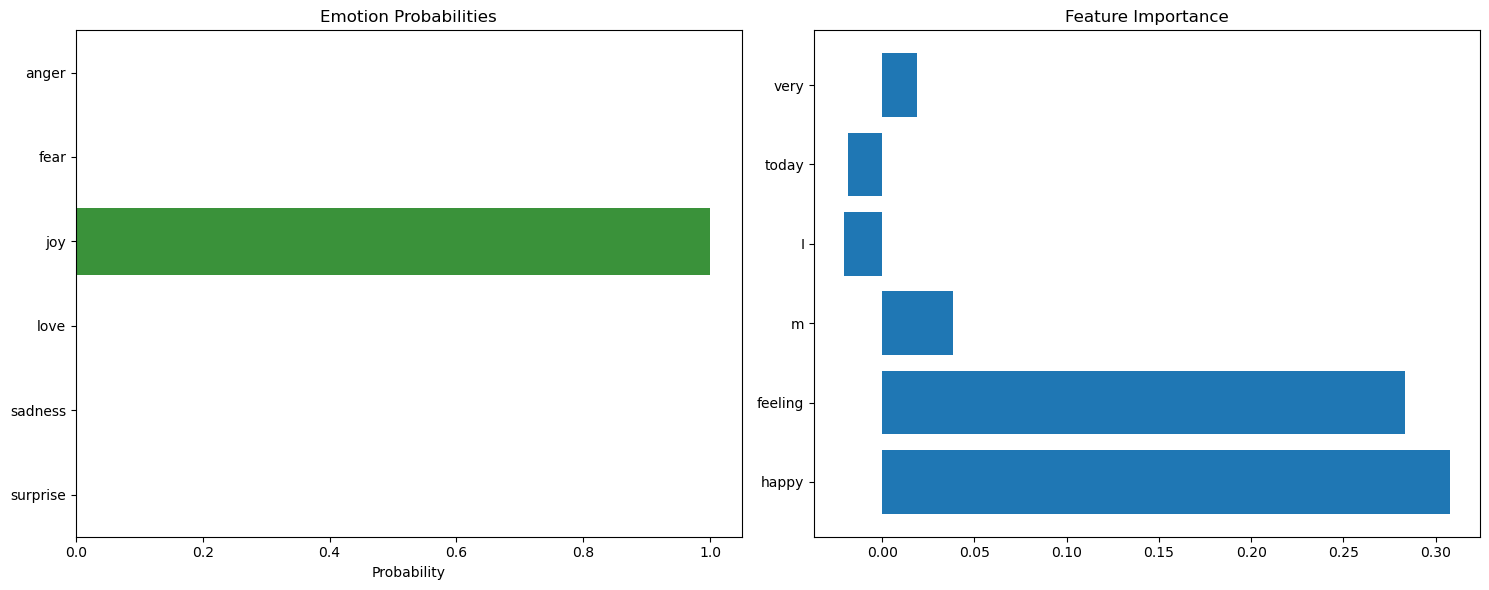

1/1 [==============================] - 0s 72ms/step


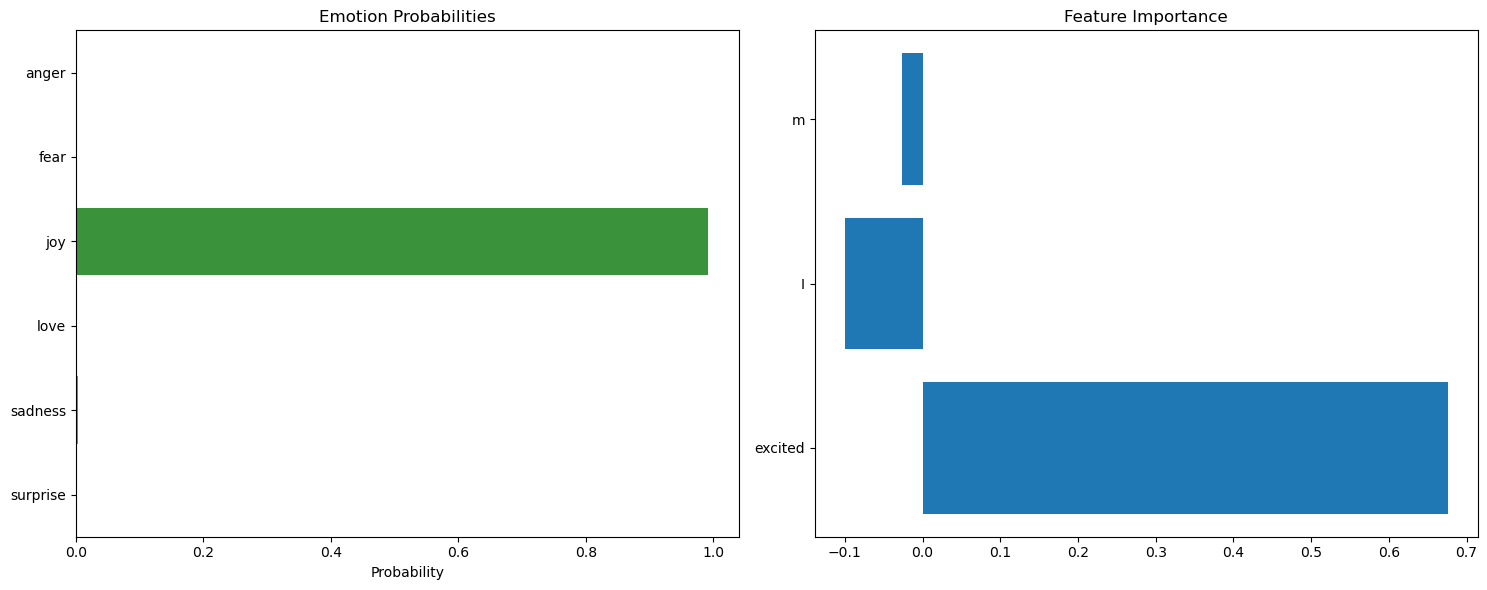

1/1 [==============================] - 0s 67ms/step


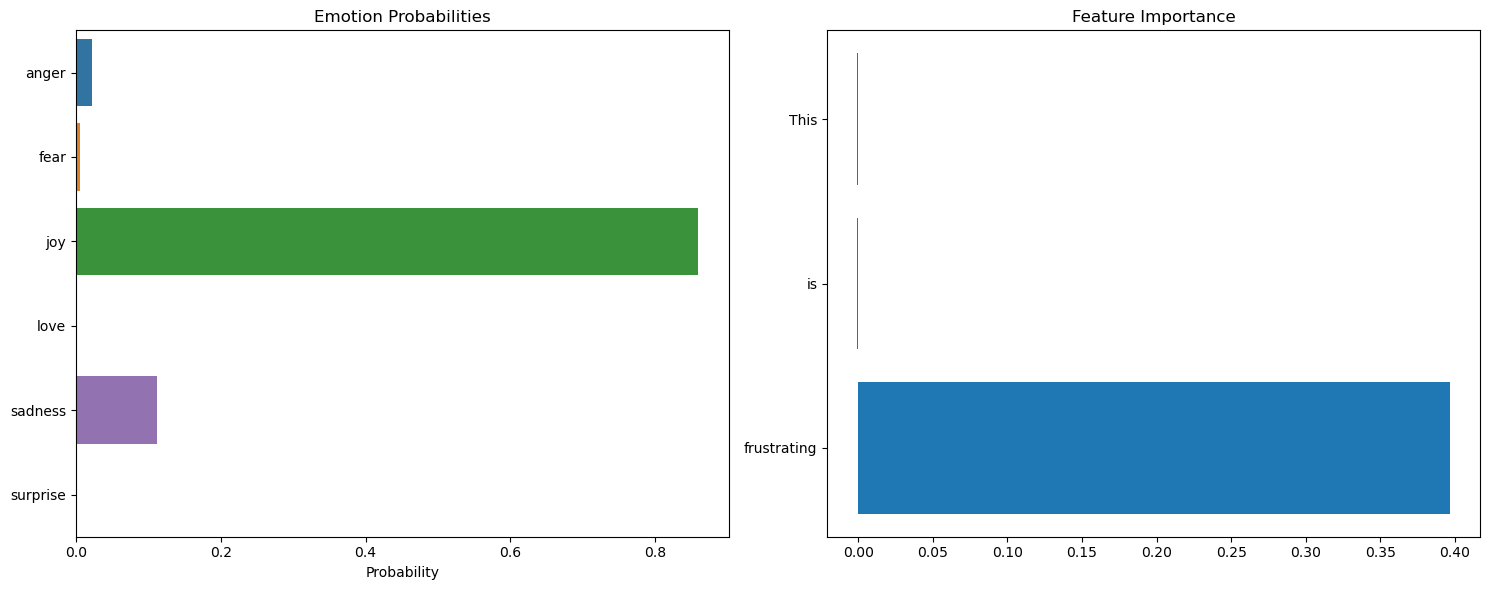

1/1 [==============================] - 0s 73ms/step


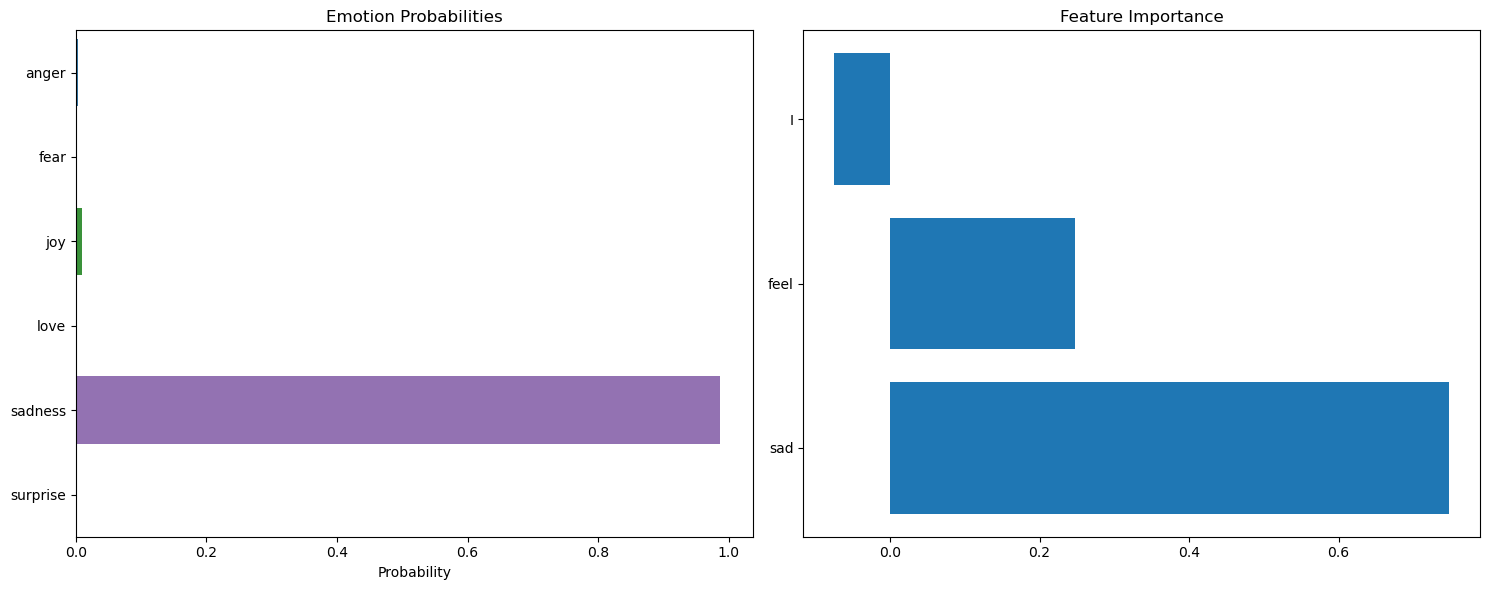

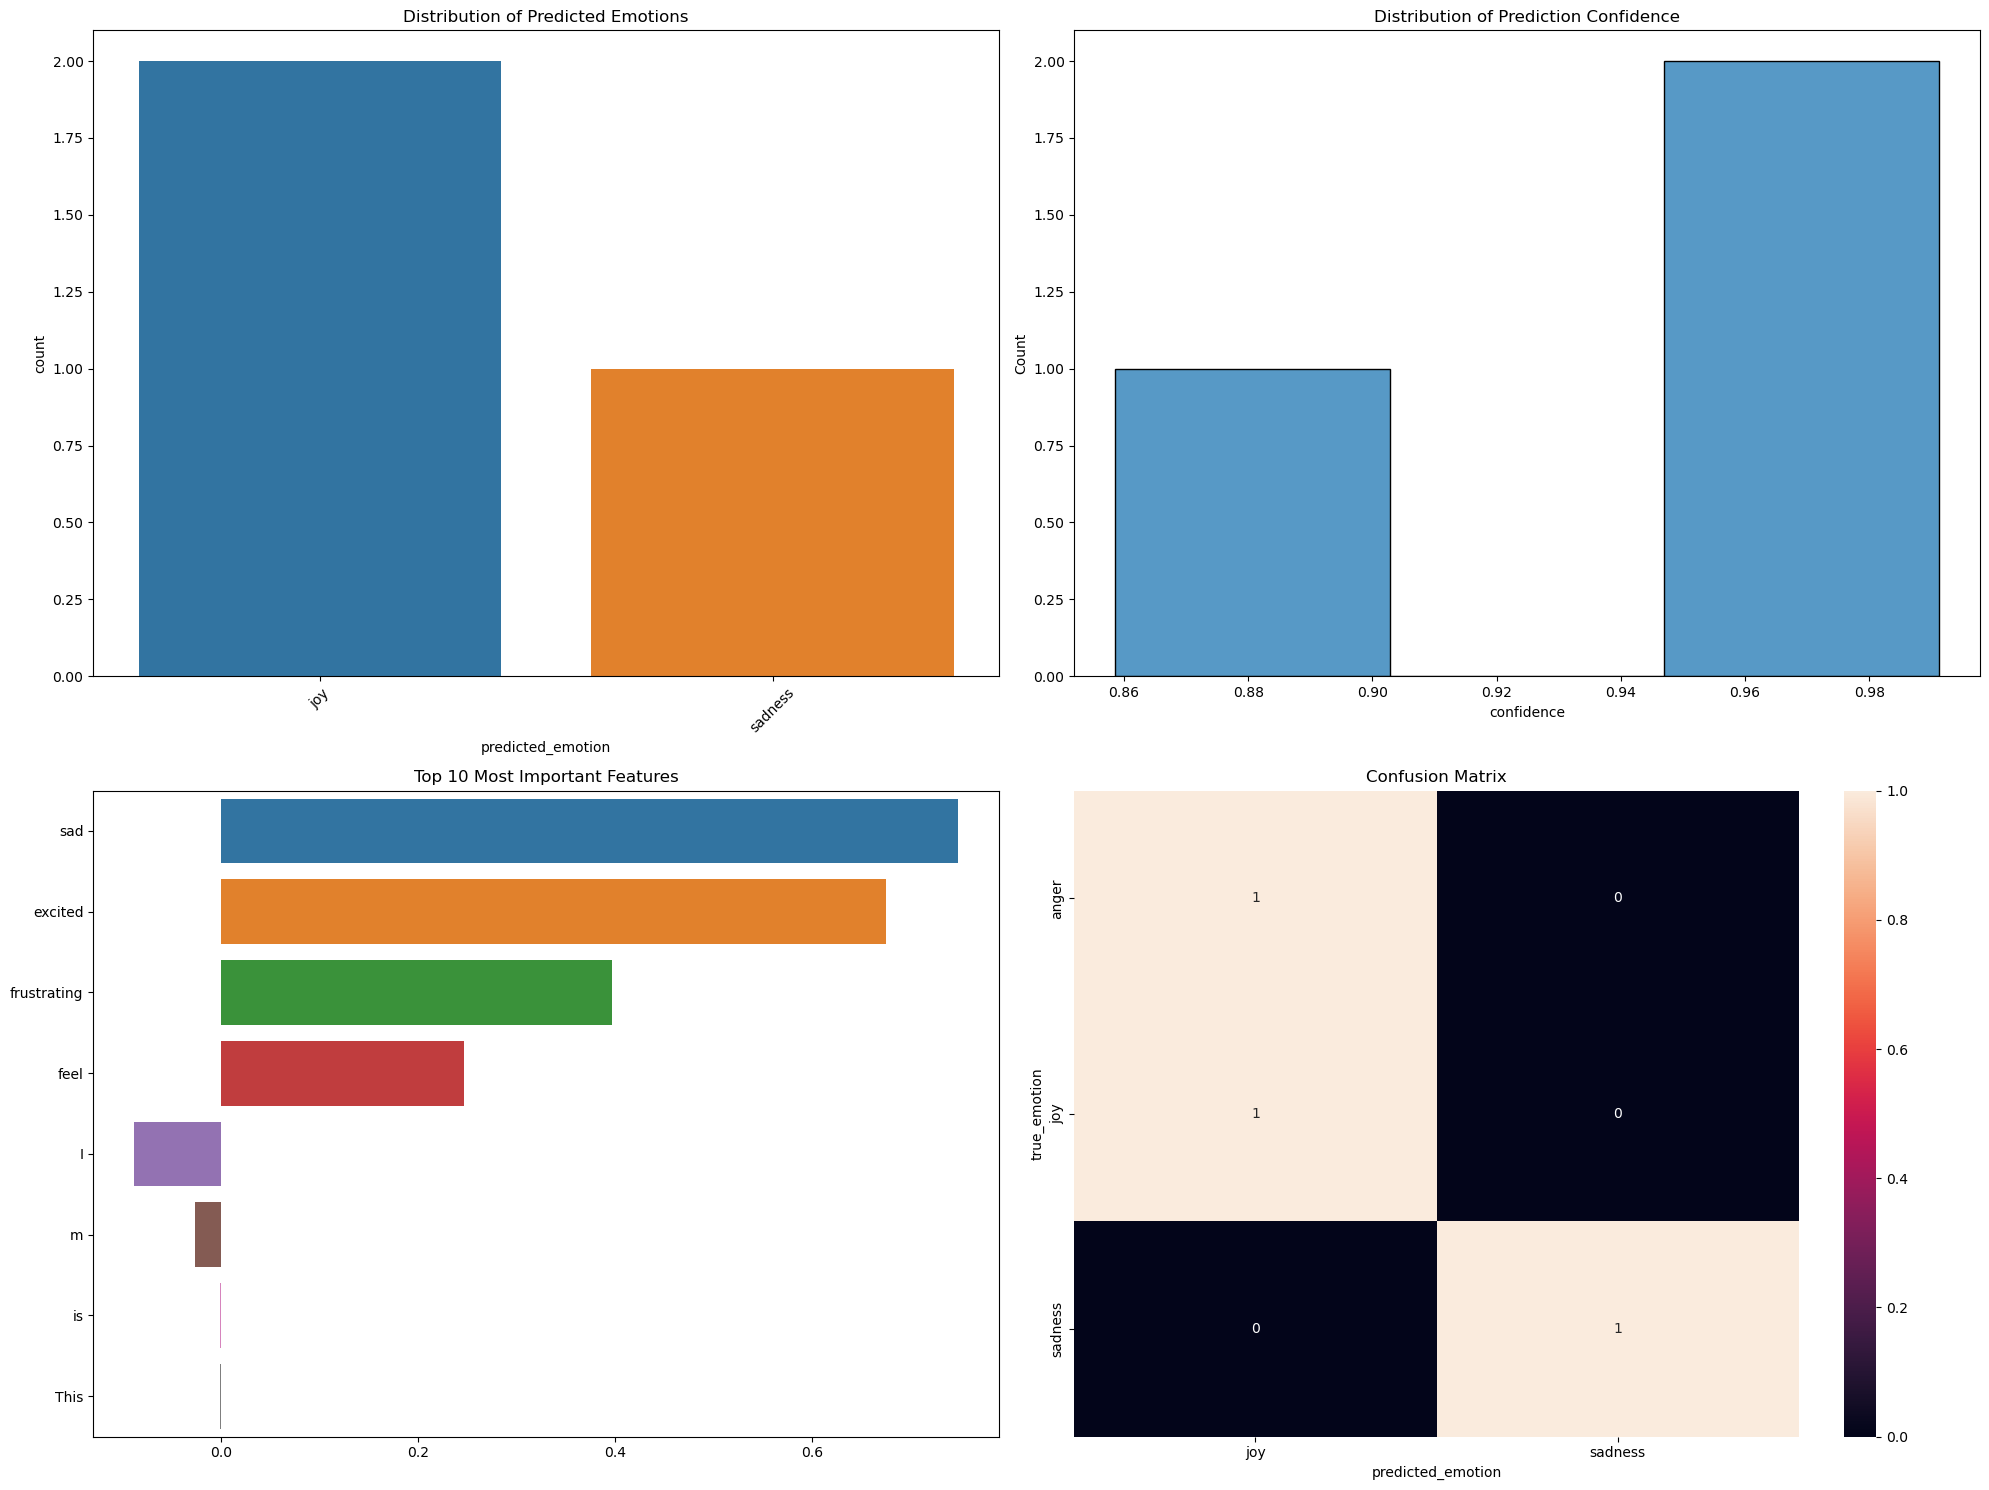

1/1 [==============================] - 0s 59ms/step


In [43]:
# First initialize the analyzer with your trained model
analyzer = EmotionLIMEAnalyzer(model, tokenizer, le)

# For single text analysis
result = analyzer.analyze_single_text("I'm feeling very happy today!")

# For analyzing multiple texts
texts = ["I'm excited!", "This is frustrating", "I feel sad"]
emotions = ["joy", "anger", "sadness"]
summary_df, avg_importance = analyzer.analyze_batch(texts, emotions)
analyzer.plot_batch_analysis(summary_df, avg_importance)

# To analyze misclassifications
misclassified = analyzer.analyze_misclassifications(summary_df)